In [1]:
from IPython.display import HTML
from IPython.display import display, HTML
from PIL import Image
from dask.distributed import Client
from dask.distributed import as_completed
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from pandas.io.formats.style import Styler
from pivottablejs import pivot_ui
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
import matplotlib
import matplotlib as mp
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_market_calendars as mcal
import pickle
import rpy2
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200


In [2]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [3]:
def evaluate_ets(npa_):
    train,test,model_func,flag_ = npa_
    
    try:
        if(len(flag)==2):
            if(flag[1] is None):
                model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],trend=flag[1],dates=train.index).fit()
            else:
                model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],dates=train.index).fit()
        else:
            model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],damped_trend=flag[2],dates=train.index).fit()

        fc_ets_ = np.exp(model.get_prediction(start=test.index[0],end=test.index[-1]).summary_frame())
        rmse_ = mean_squared_error(test, fc_ets_['mean'], squared=True)
    except:
        #not enough data points
        rmse_ = np.nan
    
    return([flag_,rmse_])

In [4]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total


In [5]:
def highlight_cells(val, color_if_true, color_if_false, threshold_):
    color = color_if_true if val >= threshold_ else color_if_false
    return 'background-color: {}'.format(color)

In [6]:
import statsmodels
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

#decision_metrics = []

def plot_(symbol_):
    print(symbol_)
    print(type(symbol_))
    print(str(symbol_))
    if(str(symbol_)=='None'):
        run=False
    else:
        run=True

    if(run):
        client = Client()
        s = symbol_
        #for s in ['CEIX']:
        msize = 2
        date_form = DateFormatter("%Y-%m-%d")

        metrics_df_ = pd.DataFrame(pd.DataFrame(screener.loc[s]).T[['volume_factor','latest_p','vol_30d_2yr','pct_2yr','adf','hurst']])

        subset=prices[prices['Symbol']==s]

        dates = []
        for t in subset.index.values:
            d = pd.Timestamp(t).strftime('%Y-%m-%d')
            dates.append(d)
            dto = datetime.strptime(d, '%Y-%m-%d').date()

        old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
        new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
        x = new_ordinal    

        lookup_index_ = []

        labels = list()
        print("symbol:",s)   

        try:
            symbol_sector = dict_sectors[sector_merged[sector_merged['Symbol']==s]['Sector'].values[0]]
            print("sector:",dict_sectors_reverse[symbol_sector])
        except:
            if(symbol_sector=='error'):
                if(np.sum([vanguard_sectors['Symbol'].values==s])):
                    symbol_sector = s
                    print("sector:",dict_sectors_reverse[symbol_sector])
            else:
                symbol_sector = 'error'
        if(symbol_sector=='error'):
            if(np.sum([vanguard_sectors['Symbol'].values==s])):
                symbol_sector = s
                print("sector:",dict_sectors_reverse[symbol_sector])
            else:
                symbol_sector = 'error'
                print("sector:",'error')

        symbol_index = temp_sm.loc[s]['index_Symbol']

        try:
            matched_index_name = spdr_indexes.iloc[np.where(spdr_indexes['Symbol'].values==s)].index[0]
        except:
            try:
                matched_index_name = temp_sm.loc[s]['index']
            except:
                matched_index_name = "none"

        print("Index:",matched_index_name)

        print("vol_30d_2yr:",screener.iloc[np.where(screener.index==s)]['vol_30d_2yr'][0])
        #print("1YMF:",subset['1YMF'].values[-1])
        print("Sector 1YMF:",screener[screener.index==s]['1YMF'][0])
        print("1YMF:",screener.iloc[np.where(screener.index==s)]['1YMF'][0])
        print("risk trend factor:",screener.iloc[np.where(screener.index==s)]['risk_trend_factor'][0])

        temp = pd.DataFrame(stock_fundamentals.loc[s])
        print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

        last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices[prices['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]

        bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']]).T
        bbands['90d_lower'] = bbands['90dSMA']-bbands['90dSDev']*2
        bbands['90d_upper'] = bbands['90dSMA']+bbands['90dSDev']*2

        bbands.index = [last_date]
        display(bbands)

        display(metrics_df_)

        mean_revert_flag = False

        if(metrics_df_['adf'][0]<.05):
            print("ADFuller H0 rejected @ .05, Mean Reverting TS")
            if(bbands['Adj Close'][0]<bbands['90d_lower'][0]):
                colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
                print(colored_text)
                mean_revert_flag = True
            if(bbands['Adj Close'][0]<bbands['21dBOLU'][0]):
                colored_text = colored(255, 0, 0, "Month Mean Reverting buy signal")
                print(colored_text)
                mean_revert_flag = True    

        l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', '30d_vol_2yr','risk_trend_factor/linear','supply_trend_1yr'],index=['blue','green','red','orange','black','yellow'],columns=['legend'])

        r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])

        display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])        

        f, (ax1, ax2, ax3) = plt.subplots(1, 5, sharey=False,figsize=(22,5))
        ax1.plot(subset['30d_vol_2yr'],color='orange')
        ax1.title('30d_vol_2yr')
        ax1.set_xticklabels(subset[['30d_vol_2yr']].dropna().index, rotation = 45)

        locator = matplotlib.dates.AutoDateLocator()
        formatter = matplotlib.dates.ConciseDateFormatter(locator)

        ax1.xaxis.set_major_locator(locator)
        ax1.xaxis.set_major_formatter(formatter)


        ax1.xaxis.set_major_formatter(date_form)

        #plt.title('30d_vol_2yr')
        ax2.plot(subset['risk_trend_factor'],color='black')
        ax2.title('risk_trend_factor')
        ax2.set_xticklabels(subset[['risk_trend_factor']].dropna().index, rotation = 45)

        locator = matplotlib.dates.AutoDateLocator()
        formatter = matplotlib.dates.ConciseDateFormatter(locator)

        ax2.xaxis.set_major_locator(locator)
        ax2.xaxis.set_major_formatter(formatter)

        ax2.xaxis.set_major_formatter(date_form)
        #plt.title('risk_trend_factor')

        #fig, ax1 = plt.subplots()   

        ax3_ = ax3.twinx()
        ax5_ = ax3.twinx()
        ax5 = ax3.twinx()
        ax4 = ax3.twinx()
        ax4_ = ax3.twinx()

        if(symbol_sector=='error'):
            pass
        else:
            if(np.sum(vanguard_sectors['Symbol'].values==s)>0):
                pass
            else:
                #print("sector",)
                #print("else_sector:",dict_sectors_reverse[s])            
                print("Sector 1YMF:",screener[screener.index==symbol_sector]['1YMF'][0])
                print("Sector Volume Factor:",screener.iloc[np.where(screener.index==symbol_sector)]['volume_factor'][0])
                print("Sector Risk Trend Factor:",screener.iloc[np.where(screener.index==symbol_sector)]['risk_trend_factor'][0])
                ax4.plot(x, (prices[prices['Symbol']==symbol_sector]['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
                #ax2.plot(x, prices[prices['Symbol']==symbol_sector]['Adj Close'],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))        
                #plt.legend([temp_sm.loc[s]['Sector']])
                #labels_ax2.append(temp_sm.loc[s]['Sector'])
                #plt.show()

        if(str(temp_sm.loc[s]['index_Symbol'])!='nan'):
            if(temp_sm.loc[s]['index_Symbol']!='error'):
                #print(temp_sm.loc[s]['index_Symbol'])
                print("Index 1YMF:",screener[screener.index==temp_sm.loc[s]['index_Symbol']]['1YMF'][0])
                print("Index Volume Factor:",screener.iloc[np.where(screener.index==temp_sm.loc[s]['index_Symbol'])]['volume_factor'][0])
                print("Index Risk Trend Factor:",screener.iloc[np.where(screener.index==temp_sm.loc[s]['index_Symbol'])]['risk_trend_factor'][0])

                ax4_.plot(x, prices[prices['Symbol']==temp_sm.loc[s]['index_Symbol']]['Adj Close'].iloc[-len(subset):],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
                #plt.plot()
                #plt.legend([temp_sm.loc[s]['index']])
                #labels_ax2.append(temp_sm.loc[s]['index'])
                #plt.show()

        y= subset['Adj Close']

        def myfunc(x):
            return slope * x + intercept

        slope, intercept, r, p, std_err = stats.linregress(x, y)

        mymodel = list(map(myfunc, x))

        ax3.plot(x, y,marker = '.',markersize=msize, color = 'b')
        ax3.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
        ax3.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
        #ax1.plot(x, subset['risk_trend_factor'],marker = '.',markersize=msize, color = 'orange')

        ax3_.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')

        ax3.plot(x, mymodel, color = 'k')
        """
        try:
            ax5.plot(x, y,marker = '.',markersize=msize, color = 'b')
            ax5.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
            ax5.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
            #ax1.plot(x, subset['risk_trend_factor'],marker = '.',markersize=msize, color = 'orange')

            ax5_.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')

            ax5.plot(x, mymodel, color = 'k')
        except:
            pass
        """
        #for l in ['symbol','1yrMax','1yrMin','risk_trend_factor','supply_trend_1yr','linear']:
            #labels.append(l)

        l = matplotlib.dates.AutoDateLocator()
        f = matplotlib.dates.ConciseDateFormatter(l)    

        ax3.set_xticklabels(ax3.get_xticks(), rotation = 45)

        locator = matplotlib.dates.AutoDateLocator()
        formatter = matplotlib.dates.ConciseDateFormatter(locator)

        ax3.xaxis.set_major_locator(locator)
        ax3.xaxis.set_major_formatter(formatter)

        ax3.xaxis.set_major_formatter(date_form)
        plt.show()

        print("ets next 13 weeks")

        #take last nyse date and extrapolate weeks from that point
        #starting from next week
        newDates = pd.date_range((subset.index[-1] + dt.timedelta(7)).strftime('%Y-%m-%d'), (subset.index[-1] + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W-'+nyse_dates.index[-1].strftime('%a')).map(lambda t: t.strftime('%Y-%m-%d'))

        print(subset.index[-1].strftime('%Y-%m-%d'))
        print(newDates[0])
        data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W-'+subset.index[-1].strftime('%a'))

        #if(np.where(np.array(list__)==s)[0][0]%batchClearLimit==0):        
        #client.restart()

        cv_inner = TimeSeriesSplit(n_splits=11,test_size=13)

        #has to be different makeup than cv_inner because there is no randomization.  Recommend a number that isn't a divisor of cv_inner's n_splits to ensure training is mixed up and not aligned
        cv_outer = TimeSeriesSplit(n_splits=10,test_size=13)

        outer_results = []

        #sm.tsa.statespace.ExponentialSmoothing
        """
        flags = []
        seasonal_flags1 = ['add','mul',None]

        trend_flags2 = ['add','mul',None]

        damped__trend_flags3 = [True,False]

        for sf in seasonal_flags1:
            for dt_ in trend_flags2:
                if(dt_ is None):          
                    for d_ in damped__trend_flags3:
                        flags.append([sf,dt_,d_])
        """

        flags = [['add', 'add', True],\
         ['add', 'add', False],\
         ['add', 'mul', True],\
         ['add', 'mul', False],\
         ['add', None],\
         ['mul', 'add', True],\
         ['mul', 'add', False],\
         ['mul', 'mul', True],\
         ['mul', 'mul', False],\
         ['mul', None],\
         [None, 'add', True],\
         [None, 'add', False],\
         [None, 'mul', True],\
         [None, 'mul', False],\
         [None, None]]

        #print(flags)

        #flags = [['T','T'],['T','F'],['F','F'],['F','T']]       

        rmse_inner_flags = []

        for flag in flags:
            #print(flag)

            npa = []

            for trainv_ix, test_ix in cv_inner.split(data.index):

                npa.append([data.iloc[trainv_ix],data.iloc[test_ix],ETSModel,flag])

            #rmses_inner = []
            #rmses_inner
            #for n in npa:
                #r = evaluate_ets(n)
                #print(r)
                #rmses_inner.append(r)
            future = client.map(evaluate_ets, npa)        

            rmses_inner = []
            #flag_order = []
            #my intent was to capture future objects vs results and this gave me results

            for f in as_completed(future):
                #exclude errors
                if(f.status=="error"):
                    #pass
                    #this causes errors with [flag,rmse] being passed by evaluate_ets
                    rmses_inner.append([flag,np.nan])
                else:
                    rmses_inner.append(f.result())

            #I don't want to keep track of flag here
            #flag_order = [r[0] for r in results_rmses].copy()
            #print(rmses_inner)
            rmse_ = [r[1] for r in rmses_inner].copy()


            #print(rmse_)
            #print(flag)
            rmse_inner_flags.append([flag,np.nanmean(rmse_),np.nanstd(rmse_)])

        #rmse_scores = []
        #flag_rmses = []

        #for fn_ in range(0,len(flags)):
            #flag_ = flags[fn_]
            #rmse_scores.append([flag_rmses[fn_],rmses[fn_][1]])

        print("inner cv scores:")
        inner_rmse_df = pd.DataFrame(rmse_inner_flags,columns=['flags','mean','std'])
        #print("inner cv scores:",[r[rmses)
        #print("inner cv sdevs:",sdevs)

        scores = inner_rmse_df['mean'].values
        sdevs = inner_rmse_df['std'].values
        best_model = inner_rmse_df['flags'].values[np.argmin(scores)]

        print("best model:",best_model)
        print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

        npa = []

        for trainv_ix, test_ix in cv_outer.split(data.index):

            npa.append([data.iloc[trainv_ix],data.iloc[test_ix],ETSModel,best_model])

        future = client.map(evaluate_ets, npa)
        results_rmses_outer = []

        #my intent was to capture future objects vs results and this gave me results
        for f in as_completed(future):
            #exclude errors
            if(f.status=="error"):
                #pass
                results_rmses_outer.append([np.nan])
            else:
                results_rmses_outer.append(f.result()) 

        test_score_mean = np.nanmean([r[1] for r in results_rmses_outer])
        test_score_std = np.nanstd([r[1] for r in results_rmses_outer])

        #test_score = [np.nanmean(rmse_outer_df['mean'].values),np.nanstd(rmse_outer_df['mean'].values)]
        print("test cv mean error, stdev (10 folds):",test_score_mean,test_score_std)

        #final_model=ETSModel(np.log(data),initialization_method='heuristic',seasonal=52,trend=F1,damped_trend=F2).fit()    
        flag = best_model
        if(len(flag)==2):
            if(flag[1] is None):
                final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],trend=flag[1],dates=data.index).fit()
            else:
                final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],dates=data.index).fit()
        else:
            final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],damped_trend=flag[2],dates=data.index).fit()

        df_pred = np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())
        #df_conf = np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).pred_int(alpha = .05))
        #df_conf.columns = ['ci_lower','ci_upper']

        #final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=['add','mul','None'][0],seasonal_periods=52,trend=['add','mul','None'][0],damped_trend=['True','False'][0],dates=data.index).fit()
        #pred = final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d'))

        #final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame()

        #df_pred = np.exp(pred.summary_frame(alpha=0.05))
        #df_pred = np.exp(pred.summary(alpha=0.05))
        s_date = df_pred.index[np.argmax(df_pred['mean'].values)].strftime('%Y-%m-%d')

        print("sell date:",s_date)
        e_return = np.array((np.max(df_pred['mean'].values)-metrics_df_['latest_p'])/metrics_df_['latest_p'])[0]
        p_metrics = pd.DataFrame(df_pred.iloc[np.argmax(df_pred['mean'].values)]).T
        #c_metrics = pd.DataFrame(df_conf.iloc[np.argmax(df_pred['mean'].values)]).T
        #print(c_metrics)
        print("expected return:",e_return)

        days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
        discounted_return = (1+e_return)**(1/days_delta)-1
        qtr_return = (1+discounted_return)**92

        print("discounted return:",discounted_return)

        print("quarter return:",qtr_return)

        #used to help filter at the end, not sdevs is chosen based on min score
        stop_loss_price = pd.DataFrame(np.mean(np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())[['mean','pi_lower']],axis=1)).iloc[0].values[0]
        #decision_metrics.append([s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]])
        decision_metrics_df = pd.DataFrame([s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]])#,columns=)#,index=[s_])#.sort_values(by='disc_rtn',ascending=False,inplace=True)
        decision_metrics_df = decision_metrics_df.T
        decision_metrics_df.columns=['SYMBOL','exp_return','sell_date','stop_loss_price','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_rmse_n11','outer_cv_std_n11','mean_revert_flag','pi_lower','pi_upper']
        decision_metrics_df.index = [symbol_]
        display(decision_metrics_df)
        #display(decision_metrics_df.style.applymap(highlight_cells, color_if_false='yellow', color_if_true='#C6E2E9', subset=['error_price_ratio','mean_revert_flag','std_price_ratio'], threshold_=.75))

        temp_price = data.tail(13)
        temp_price.columns = ['mean']
        plt.plot(pd.concat([temp_price,df_pred],axis=0))
        #plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
        plt.xticks(rotation = 45,size=8)
        plt.show()

        if(np.sum(np.array(fundamental_entries)==s)>0):
            loc = np.where(np.array(fundamental_entries)==s)[0][0]
            #print(fundamentals_quarterlies[loc[0]][0])
            #fundamentals_quarterlies[loc][1]
            for item in fundamentals_quarterlies[loc][1]:
                if(type(item[1]) == type(None)):
                    pass
                else:
                    if(len(item[1])>0):
                        #print(len(item[1]))
                        print(item)
        client.close()

In [7]:
db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

Database exists, assume schema does, too.


In [8]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [9]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [10]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [11]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [12]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [13]:
stock_fundamentals = market_data
screener = screener_sorted
fundamentals = stock_fundamentals
stock_indexes = sp1500_index_df

spdr_indexes = indexes
spdr_indexes.columns=['Symbol']
vanguard_sectors = sectors
vanguard_sectors.columns=['Symbol']

In [14]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]:
    subset = prices[prices['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [15]:
sector_performance_Q_smoothed_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
sector_performance_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]

In [16]:
"""
from scipy import stats as st
from scipy.stats import t

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

warnings.filterwarnings('ignore')
for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 

display(B.style.apply(b_g,cmap=cm))

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5

print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]/np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)

display(p_values.style.applymap(highlight_cells, color_if_true='green', color_if_false='yellow', threshold_=.5))

p_values.hist()
"""

'\nfrom scipy import stats as st\nfrom scipy.stats import t\n\nstd_indexes = pd.DataFrame()\nseasonal_indexes = pd.DataFrame()\n\nwarnings.filterwarnings(\'ignore\')\nfor spr in sector_performance_return.columns:\n    #print(spr)\n    s = sector_performance_return[[spr]]\n    #print(s)\n    years = []\n    quarters = []\n    for d in sector_performance_return[spr].index:\n\n        d_ = d.strftime(\'%Y-%m-%d\')\n        #print(d_)\n\n        datem = dt.datetime.strptime(d_, "%Y-%m-%d")\n        years.append(str(datem.year))\n        #print(datem.year)       # 2021\n        m = datem.month\n        d = datem.day\n        if(len(str(m))==1):\n            m = \'0\'+str(m)\n        else:\n            m = str(m)\n        if(len(str(d))==1):\n            d = \'0\'+str(d)\n        else:\n            d = str(d)\n        quarters.append(m+"-"+d)\n\n    s[\'Years\'] = years\n    s[\'Quarters\'] = quarters\n    ct = pd.crosstab(s[\'Years\'], s[\'Quarters\'],values=s[spr],aggfunc=np.mean).mean(axi

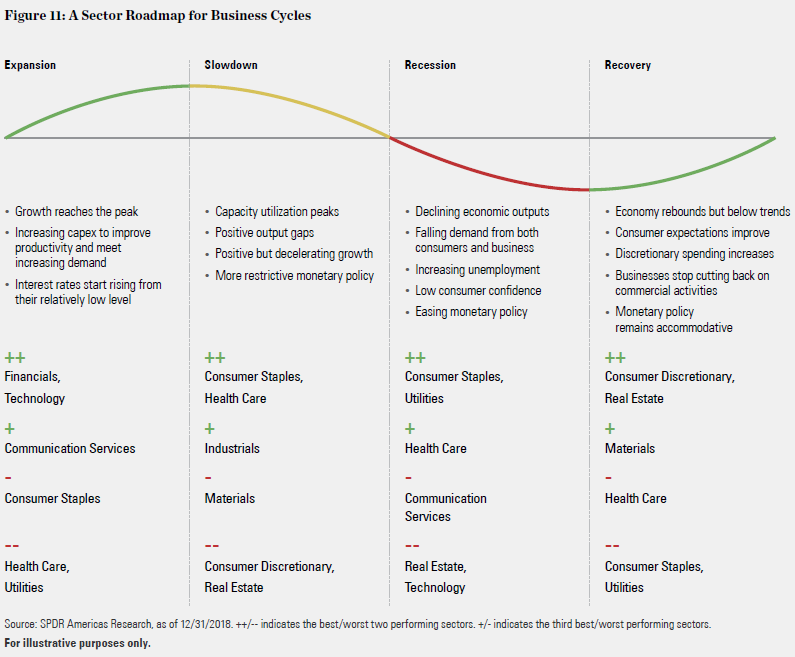

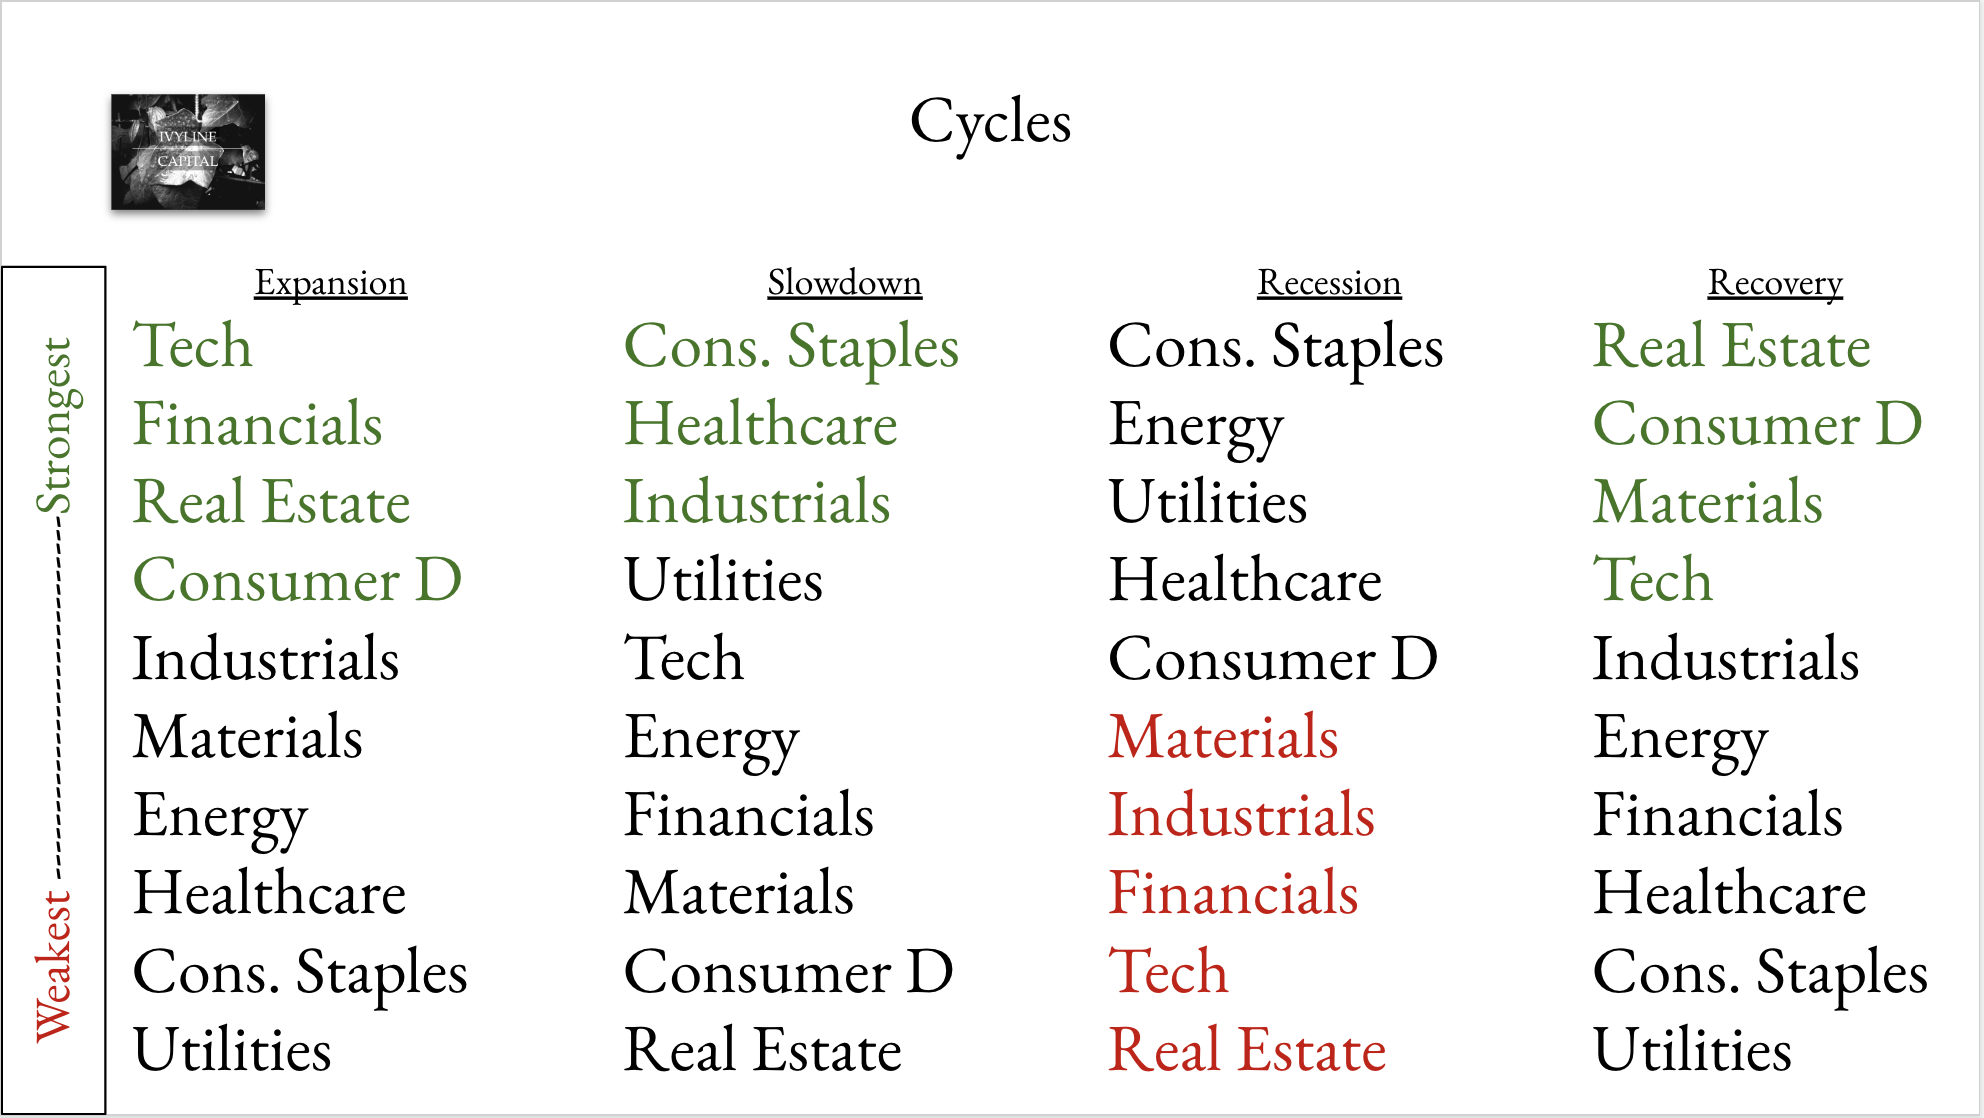

In [17]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\reports\figures\Business cycles.png"
display(Image.open(path))
path=r"C:\Users\User\Documents\wiki\wiki\Finance\Business Cycles-2.png"
display(Image.open(path))

In [18]:
sector_performance_return_pvt = sector_performance_return[sector_performance_return.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_return.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    
A = sector_performances_values
B = sector_performances

df = B.style.apply(b_g,cmap='RdYlGn')

display(df)


,Energy ETF,Consumer Staples ETF,Utilities ETF,Health Care ETF,Materials ETF,SP600,Industrials ETF,SP1500,SP500,Financials ETF,Real Estate ETF,SP400,Information Technology ETF,Communication Services ETF,Consumer Discretionary ETF
2017-03-31 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-06-30 00:00:00,-0.078709,0.010040,0.022113,0.072895,0.026999,0.018327,0.042167,0.030375,0.030708,0.038955,0.017375,0.031752,0.041388,-0.024136,0.028386
2017-09-30 00:00:00,0.069612,-0.012346,0.031518,0.040565,0.066617,0.064962,0.052781,0.044807,0.045666,0.052789,0.008095,0.035020,0.083223,0.015498,0.014521
2017-12-31 00:00:00,0.073946,0.059268,0.000687,0.018576,0.071798,0.038747,0.066175,0.066880,0.069917,0.073683,0.012742,0.074139,0.093087,0.000763,0.097848
2018-03-31 00:00:00,-0.078807,-0.073521,-0.033734,-0.020049,-0.072483,-0.011631,-0.033542,-0.021321,-0.024130,-0.015065,-0.086159,-0.003978,0.020711,-0.085669,-0.001942
2018-06-30 00:00:00,0.150528,0.006353,0.053422,0.055259,0.036210,0.106722,-0.008057,0.052094,0.047568,-0.011331,0.094633,0.045520,0.080437,0.035862,0.088528
2018-09-30 00:00:00,0.021911,0.050064,0.019751,0.137698,0.007338,0.032842,0.094874,0.070536,0.078236,0.031675,0.000044,0.032902,0.117719,0.023115,0.066008
2018-12-31 00:00:00,-0.267451,-0.055862,0.009925,-0.108129,-0.154310,-0.193040,-0.183620,-0.142834,-0.137319,-0.138848,-0.058855,-0.172165,-0.174415,-0.143117,-0.162070
2019-03-31 00:00:00,0.178564,0.111156,0.103055,0.081835,0.126958,0.124660,0.183161,0.151853,0.144236,0.109942,0.173365,0.157497,0.217473,0.139541,0.157197
2019-06-30 00:00:00,-0.048754,0.036556,0.035855,0.017469,0.040951,0.010843,0.034436,0.039106,0.040369,0.067026,0.015389,0.030815,0.054745,0.035928,0.040127


,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00,2018-03-31 00:00:00,2018-06-30 00:00:00,2018-09-30 00:00:00,2018-12-31 00:00:00,2019-03-31 00:00:00,2019-06-30 00:00:00,2019-09-30 00:00:00,2019-12-31 00:00:00,2020-03-31 00:00:00,2020-06-30 00:00:00,2020-09-30 00:00:00,2020-12-31 00:00:00,2021-03-31 00:00:00,2021-06-30 00:00:00,2021-09-30 00:00:00,2021-12-31 00:00:00,2022-03-31 00:00:00,2022-06-21 00:00:00
0,SP1500,Health Care ETF,Information Technology ETF,Consumer Discretionary ETF,Information Technology ETF,Energy ETF,Health Care ETF,Utilities ETF,Information Technology ETF,Financials ETF,Utilities ETF,Health Care ETF,Information Technology ETF,Consumer Discretionary ETF,Consumer Discretionary ETF,SP600,Energy ETF,Energy ETF,Financials ETF,Information Technology ETF,Energy ETF,Energy ETF
1,SP500,Industrials ETF,Energy ETF,Information Technology ETF,Consumer Discretionary ETF,SP600,Information Technology ETF,Consumer Staples ETF,Industrials ETF,Information Technology ETF,Real Estate ETF,Information Technology ETF,Health Care ETF,Energy ETF,Materials ETF,Energy ETF,SP600,Real Estate ETF,Information Technology ETF,Real Estate ETF,Utilities ETF,Consumer Staples ETF
2,SP600,Information Technology ETF,Materials ETF,SP400,SP400,Real Estate ETF,Industrials ETF,Real Estate ETF,Energy ETF,Materials ETF,Consumer Staples ETF,Financials ETF,Utilities ETF,Information Technology ETF,Information Technology ETF,Financials ETF,Financials ETF,Information Technology ETF,Utilities ETF,Materials ETF,Materials ETF,Utilities ETF
3,SP400,Financials ETF,SP600,Energy ETF,SP600,Consumer Discretionary ETF,SP500,Health Care ETF,Real Estate ETF,SP500,Information Technology ETF,SP1500,Consumer Staples ETF,Materials ETF,Industrials ETF,SP400,Industrials ETF,Communication Services ETF,SP500,Utilities ETF,Consumer Staples ETF,Health Care ETF
4,Communication Services ETF,SP400,Financials ETF,Financials ETF,Financials ETF,Information Technology ETF,SP1500,SP500,SP400,Consumer Discretionary ETF,Financials ETF,SP500,Communication Services ETF,SP400,Consumer Staples ETF,Communication Services ETF,Materials ETF,SP500,SP1500,Consumer Staples ETF,Financials ETF,Materials ETF
5,Consumer Discretionary ETF,SP500,Industrials ETF,Materials ETF,Health Care ETF,Health Care ETF,Consumer Discretionary ETF,Financials ETF,Consumer Discretionary ETF,SP1500,SP500,Communication Services ETF,SP500,Communication Services ETF,Communication Services ETF,Industrials ETF,Real Estate ETF,Health Care ETF,Health Care ETF,SP500,Industrials ETF,SP600
6,Consumer Staples ETF,SP1500,SP500,SP500,SP1500,Utilities ETF,Consumer Staples ETF,SP1500,SP1500,Consumer Staples ETF,SP1500,SP600,SP1500,SP600,SP500,Consumer Discretionary ETF,SP400,SP1500,Real Estate ETF,SP1500,Health Care ETF,Industrials ETF
7,Energy ETF,Consumer Discretionary ETF,SP1500,SP1500,SP500,SP1500,SP400,Communication Services ETF,SP500,Communication Services ETF,Industrials ETF,Materials ETF,Consumer Discretionary ETF,SP1500,SP1500,Materials ETF,Communication Services ETF,Financials ETF,Consumer Discretionary ETF,Consumer Discretionary ETF,SP500,SP1500
8,Financials ETF,Materials ETF,Health Care ETF,Industrials ETF,Industrials ETF,SP500,SP600,Materials ETF,Communication Services ETF,Utilities ETF,Consumer Discretionary ETF,SP400,Real Estate ETF,SP500,SP400,Information Technology ETF,Consumer Discretionary ETF,Consumer Discretionary ETF,Consumer Staples ETF,Industrials ETF,SP1500,SP500
9,Health Care ETF,Utilities ETF,SP400,Consumer Staples ETF,Utilities ETF,SP400,Financials ETF,Consumer Discretionary ETF,Materials ETF,Industrials ETF,Communication Services ETF,Industrials ETF,SP400,Industrials ETF,Health Care ETF,SP1500,SP1500,Materials ETF,Communication Services ETF,Health Care ETF,SP600,Financials ETF


In [19]:
"""
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
display(df_sea_adj)
"""

'\n#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)\n#pd.crosstab(shares_viz[\'Year\'], shares_viz[\'Month\'])\n\n#seasonal_indexes[si]\nseasonally_adjusted = pd.DataFrame()\n\nfor s in sector_performance_return.columns:\n    \n    s_ = pd.DataFrame(sector_performance_return[s])\n    #print(sector_performance_return[s])\n    years = []\n    quarters = []\n    \n    for d in s_.index:\n        d_ = d.strftime(\'%Y-%m-%d\')\n        #print(d_)\n\n        datem = dt.datetime.strptime(d_, "%Y-%m-%d")\n        years.append(str(datem.year))\n        #print(datem.year)       # 2021\n        m = datem.month\n        d = datem.day\n        if(len(str(m))==1):\n            m = \'0\'+str(m)\n        else:\n            m = str(m)\n        if(len(str(d))==1):\n            d = \'0\'+str(d)\n        else:\n            d = str(d)\n        quarters.append(m+"-"+d)\n        \n    s_[\'Quarter\'] = quarters\n    si_ = seasonal_indexes.loc[s]\n    \n    modified = pd.DataFrame()\n    #print

In [20]:
index_performance = []
for v in spdr_indexes['Symbol'].values:
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_i = pd.DataFrame(index_performance,index=spdr_indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=spdr_indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted

,Index,Symbol,risk_trend_factor
0,SP500,SPY,-3.855535
1,SP1500,SPTM,-4.000000
2,SP400,MDYG,-5.284705
3,SP600,SLY,-5.743669


In [21]:
sector_performance = []
for v in vanguard_sectors['Symbol'].values:
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_v = vanguard_sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted

,Symbol,risk_trend_factor,Sector
3,VDE,0.398771,Energy ETF
2,VDC,-2.069745,Consumer Staples ETF
10,VPU,-2.199488,Utilities ETF
8,VAW,-3.000576,Materials ETF
9,VNQ,-3.121982,Real Estate ETF
5,VHT,-3.455703,Health Care ETF
7,VGT,-4.675846,Information Technology ETF
6,VIS,-4.796059,Industrials ETF
1,VCR,-4.922558,Consumer Discretionary ETF
4,VFH,-5.109940,Financials ETF


Rolling Quarterly Mean Return


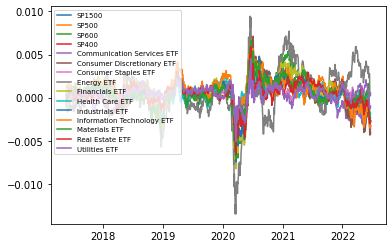

In [22]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]],loc=2,fontsize=7)
plt.show()

Quarterly Returns


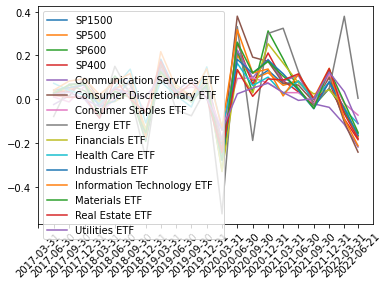

In [23]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


In [24]:
"""
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()
"""

'\nplt.plot(seasonal_indexes[si].T)\nplt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)\nplt.show()\n'

In [25]:
threshold = 0

In [26]:
screener_sorted_ = screener_sorted.reset_index().merge(stock_indexes,on='Symbol',how='left')

screener_good = screener_sorted_[screener_sorted_['risk_trend_factor']!='missing']

risk_trend_threshold = screener_good['risk_trend_factor'].quantile(q=[threshold]).values[0]


In [27]:
risk_trend_threshold

-43.46306320705355

In [28]:
stock_sectors = stock_fundamentals['sector']

In [29]:
temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener[['risk_trend_factor']].merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']
temp_sm = temp_sm.merge(spdr_indexes.reset_index(), on='index', how='left')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index','index_Symbol']
temp_sm.index = sector_merged['Symbol']

for spdr_ in range(0,len(spdr_indexes['Symbol'].values)):
    spdr__ = spdr_indexes['Symbol'].values[spdr_]
    spdr__i = spdr_indexes['Symbol'].index[spdr_]
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__

C:\Users\User\AppData\Local\Temp\ipykernel_4872\2744307430.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

array([[<AxesSubplot:title={'center':'risk_trend_factor'}>]], dtype=object)

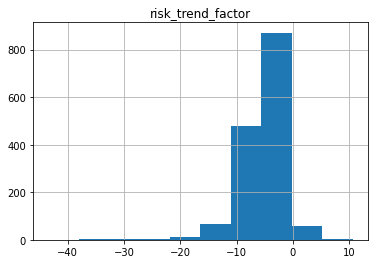

In [30]:
screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [31]:
len(screener)

1520

In [32]:
prices_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Symbol',
       'trailing_1yr_max', 'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'trailing_1yr_min', 'supply_trend_1yr',
       'supply_trend_60d', 'supply_trend_30d', 'trailing_60d_max',
       'trailing_60d_min', 'trailing_30d_max', 'trailing_30d_min', '90dSMA',
       '90dSDev', 'TP', '21dstdTP', '21dMA-TP', '21dBOLU', '21dBOLD',
       'trailing_risk_40d_max', 'trailing_risk_40d_min', 'risk_per_share',
       '30d_vol', '30d_vol_2yr', 'volume_factor', '1YMF', 'risk_trend_factor'],
      dtype='object')

In [33]:
risk_screened = screener_good[(screener_good['risk_trend_factor']>risk_trend_threshold) & (screener_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
temp_df = risk_screened[['Symbol','latest_p','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','volume_factor','adf','hurst','Sector','Market Index']]
temp_df.set_index('Symbol',inplace=True)
#pd.concat([temp_df,temp_sm],axis=0)

Index(['Symbol', 'max_2y', 'min_2y', 'std_2y', 'mean_2y', 'max_1y', 'min_1y',
       'std_1y', 'mean_1y', 'latest_p', '2yr_close_0pct', '2yr_close_2pct',
       '2yr_close_9pct', '2yr_close_25pct', '2yr_close_50pct',
       '2yr_close_75pct', '2yr_close_91pct', '2yr_close_98pct',
       '2yr_close_100pct', '1yr_close_0pct', '1yr_close_2pct',
       '1yr_close_9pct', '1yr_close_25pct', '1yr_close_50pct',
       '2yr_close_75pct', '1yr_close_91pct', '1yr_close_98pct',
       '1yr_close_100pct', 'risk_trend_factor', 'supply_trend_1yr',
       'supply_trend_60d', 'supply_trend_30d', 'vol_30d_2yr', 'pct_1yr',
       'pct_2yr', 'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'vol_30d', 'volume_factor', 'adf', 'hurst',
       '1YMF', 'Market Index', 'Sector'],
      dtype='object')


In [34]:

screened_final_set = risk_screened

In [35]:
fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))

In [36]:
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

In [37]:
summary = pd.DataFrame()

In [38]:
summary = pd.DataFrame()
for name_ in np.unique(prices_df['Symbol'].values):
    summary = pd.concat([summary,pd.DataFrame(prices_df[prices_df['Symbol']==name_][['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor']].iloc[-1]).T.reset_index().set_index('Symbol')],axis=0)

KeyboardInterrupt: 

In [ ]:
threshold

In [ ]:
threshold_value = summary.dropna()['risk_trend_factor'].quantile([threshold])

In [ ]:
risk_trend_factor_sector_dict = dict()
for s in sectors['Symbol']:
    risk_trend_factor_sector_dict[s] = prices_df[prices_df['Symbol']==s]['risk_trend_factor'].values[-1]
    
risk_trend_factor_sector_dict['error']='error'    

In [ ]:
inv_dict_map = {v: k for k, v in dict_indexes.items()}
inv_dict_map[np.nan] = 'error'
in_ = [inv_dict_map[t[0]] for t in temp_sm[['index']].values]
se_ = [dict_sectors[t[0]] for t in temp_sm[['Sector']].values]
#temp_sm[['Sector','index']]
symbols_w_index_sector = pd.concat([pd.DataFrame(se_,columns=['index'],index=temp_sm.index),pd.DataFrame(in_,columns=['sector'],index=temp_sm.index)],axis=1)

In [ ]:
symbols_w_sector_rtf = pd.DataFrame([risk_trend_factor_sector_dict[s] for s in symbols_w_index_sector['index'].values],columns=['sector_risk_trend_factor'],index=symbols_w_index_sector.index)

In [ ]:
rick_screener = pd.concat([summary.sort_values(by='risk_trend_factor',ascending=False).iloc[:,1:],symbols_w_index_sector,symbols_w_sector_rtf,temp_sm[['index','Sector']]],axis=1)

In [ ]:
list_sector_n_indexes = []
list_stocks = []
for i in index_risk_sorted['Symbol'].values:
    list_sector_n_indexes.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_sector_n_indexes.append(i)
#for i in screened_final_set['Symbol'].values:
for i in sp1500_index_df['Symbol'].values:
    list_stocks.append(i)
stocks_ = list_stocks
#stocks_ = np.unique(list_stocks, return_index=True)[1]
#list__ = [list_[symbol] for symbol in sorted(stocks_)]
#list__ = ['MCK','MPC','APA','LNTH','MUSA','CIVI','VAW','VGT','EQT','XOM','DVN','MRO','EOG','HES','CEIX','SM','RRC','MUR','MTDR','PXD','OXY','PDCE','NFG','FANG','TWI','PBF','MANT','HRB','VDC','ACC','GO','TVTY','FCN','VIVO']

In [ ]:
rick_screener_final = rick_screener.dropna()[rick_screener.dropna()['risk_trend_factor'].values > threshold_value.values[0]]
rick_screener_final = pd.concat([rick_screener,rick_screener_final],axis=0).drop_duplicates(keep='last')

diff_ = np.setdiff1d(np.array([*list_sector_n_indexes,*stocks_]),rick_screener_final.index)

for d in diff_:
    rick_screener_final = pd.concat([rick_screener_final,pd.DataFrame([np.repeat(np.nan, len(rick_screener_final.columns))],columns=rick_screener_final.columns,index=[d])],axis=0)

In [ ]:

#len(np.setdiff1d(list_sector_n_indexes,rick_screener_final.index))

In [ ]:
rick_screener_final.loc[np.setdiff1d([*rick_screener_final.index],list_sector_n_indexes)].sort_values(by='risk_trend_factor',ascending=False).head(50)

In [ ]:
rick_screener_final.loc[np.setdiff1d([*rick_screener_final.index],list_sector_n_indexes)].sort_values(by='risk_trend_factor',ascending=False).to_csv('rick_screener_final.csv')

In [ ]:
#completed_fred_pvt_df = completed_fred_pvt.asfreq('D').reindex(nyse_dates.index).interpolate(method='time')
completed_fred_pvt_df = completed_fred_pvt

temp_new = completed_fred_pvt.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates.index)
temp_dates = pd.date_range(completed_fred_pvt.index[0].strftime('%Y-%m-%d'), completed_fred_pvt.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
nyse_inbetween_temp_dates = nyse_dates.index[(nyse_dates.index >= temp_dates[0]) & (nyse_dates.index <= temp_dates[-1])]
temp_new = temp_new.reindex(nyse_inbetween_temp_dates)

completed_fred_pvt_df = temp_new
completed_fred_pvt_df.columns = [name[1] for name in completed_fred_pvt_df.columns]

In [ ]:
fred_friendly_names = ['Market volatility','Consumer Confidence','Unemployment','Inflation','Interest Rates','10 Year to 3 Month','Recession Indicator']
fred_names = ['VIXCLS','UMCSENT','UNRATE','FPCPITOTLZGUSA','FEDFUNDS','T10Y3M','USREC']
print('nominal,','pct_change,','pct_change().cumsum')
for pos in range(0,len(fred_names)):
    print(fred_friendly_names[pos])
    name = fred_names[pos]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(15,6))
    ax1.plot(completed_fred_pvt_df[name])
    ax2.plot(completed_fred_pvt_df[name].pct_change())
    ax3.plot(completed_fred_pvt_df[name].pct_change().cumsum())
    plt.show()

In [ ]:
#screener['vol_30d_2yr']

In [ ]:
#pd.DataFrame(np.mean(np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())[['mean','pi_lower']],axis=1)).iloc[0].values[0]
#[s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]]
#screener['latest_p'].loc[decision_metrics_df.index]

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

#batchClearLimit = round(len(list__)/7)

print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*spdr_indexes['Symbol'].values,*vanguard_sectors['Symbol'].values,"""

widgets.Dropdown(
    #options=stocks_,
    #value=None,
    description='Choose Stock:',
    disabled=False,
)

#y_=widgets.Select(options=stocks_,disabled=False)
y_=widgets.Select(options=np.sort([*list_sector_n_indexes,*list_stocks]),value=None,disabled=False)

a=interact(plot_,symbol_=y_)
